# Taha Samavati - 98722134
## NLP Final Project / Fall-Winter 1398 / Dr.Minaei

*Supervised Learning of Sentence Representation based on stanford natural language inference data (InferSent)*



In [0]:
# Imports
import numpy as np
import pandas as pd
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from keras.layers import LSTM, GRU, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, \
      concatenate, Conv1D, Lambda, multiply, Dense,subtract,TimeDistributed
import keras.backend as K
from keras import Model
import os
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
from keras import backend as K, initializers, regularizers, constraints
from keras.engine.topology import Layer
from keras.utils import plot_model
from keras.models import load_model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

# 1. Load and Preprocessing of data set

In [0]:
# download dataset and unzip it
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip -P /content/gdrive/My\ Drive/NLP/
!wget https://www.nyu.edu/projects/bowman/multinli/multinli_1.0.zip -P /content/gdrive/My\ Drive/NLP/

!unzip /content/gdrive/My\ Drive/NLP/snli_1.0.zip -d /content/gdrive/My\ Drive/NLP/
!unzip /content/gdrive/My\ Drive/NLP/multinli_1.0.zip -d /content/gdrive/My\ Drive/NLP/

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip -P /content/gdrive/My\ Drive/NLP/
!unzip /content/gdrive/My\ Drive/NLP/wiki-news-300d-1M.vec.zip -d /content/gdrive/My\ Drive/NLP/

! wget "http://nlp.stanford.edu/data/glove.6B.zip" -O glove.6B.zip && unzip glove.6B.zip

Archive:  /content/gdrive/My Drive/NLP/wiki-news-300d-1M.vec.zip
replace /content/gdrive/My Drive/NLP/wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/gdrive/My Drive/NLP/wiki-news-300d-1M.vec  


In [0]:
def onehot(labels):

  # integer encode
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(labels)

  # binary encode
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  return onehot_encoded

# read dataset
snli_train = pd.read_csv('/content/gdrive/My Drive/NLP/snli_1.0/snli_1.0_train.txt',sep="\t")
snli_dev = pd.read_csv('/content/gdrive/My Drive/NLP/snli_1.0/snli_1.0_dev.txt', sep="\t")
snli_test = pd.read_csv('/content/gdrive/My Drive/NLP/snli_1.0/snli_1.0_test.txt', sep="\t")

# preprocess drop nan entries and ignore entries with no label
snli_train = snli_train.dropna(subset = ['sentence2'])
snli_train = snli_train[snli_train["gold_label"] != "-"]
snli_dev = snli_dev[snli_dev["gold_label"] != "-"]
snli_test = snli_test[snli_test["gold_label"] != "-"]

# construct label arrays
y_train = snli_train['gold_label']
y_val = snli_dev['gold_label']
y_test = snli_test['gold_label']

# constrauct X_train arrays
x_train_raw = snli_train[['sentence1','sentence2']]
x_val_raw = snli_dev[['sentence1','sentence2']]
x_test_raw = snli_test[['sentence1','sentence2']]

# one hot encode labels
y_train_e = onehot(y_train)
y_val_e = onehot(y_val)
y_test_e = onehot(y_test)

* FastText was used as The Word Embedding Model. (300 dim - wiki-news)
* in the preceeding cells :


1.   Load and read fasttext model
2.   Create corpus out of all sentences in dataset
3.   Fit Tokenizer on whole corpus
4.   Convert text to sequence
5.   Zero padd sequences



In [0]:
# 1.Load and read fasttext model

embeddings_index = {}
with open('/content/gdrive/My Drive/NLP/wiki-news-300d-1M.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
'''
# 1.Load and read glove model
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
'''

In [0]:
# 2.Create corpus out of all sentences in dataset
main_train, hypo_train, main_val, hypo_val, main_test, hypo_test=[], [], [], [], [], []

for entry in x_train_raw['sentence1']:
  main_train.append(entry)
for entry in x_train_raw['sentence2']:
  hypo_train.append(entry)
for entry in x_val_raw['sentence1']:
  main_val.append(entry)
for entry in x_val_raw['sentence2']:
  hypo_val.append(entry)
for entry in x_test_raw['sentence1']:
  main_test.append(entry)
for entry in x_test_raw['sentence2']:
  hypo_test.append(entry)

corpus = main_train + hypo_train + main_val + hypo_val
# 3.Fit Tokenizer on whole corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
del corpus # delete to free memmory

In [0]:
# 4.Convert text to sequence
main_sequences = tokenizer.texts_to_sequences(main_train)
hypo_sequences = tokenizer.texts_to_sequences(hypo_train)
main_sequences_val = tokenizer.texts_to_sequences(main_val)
hypo_sequences_val = tokenizer.texts_to_sequences(hypo_val)
main_sequences_test = tokenizer.texts_to_sequences(main_test)
hypo_sequences_test = tokenizer.texts_to_sequences(hypo_test)
# 5.Zero pad sequences
main_seq_padded = pad_sequences(main_sequences, maxlen=82)
hypo_seq_padded = pad_sequences(hypo_sequences, maxlen=82)
main_seq_padded_val = pad_sequences(main_sequences_val, maxlen=82)
hypo_seq_padded_val = pad_sequences(hypo_sequences_val, maxlen=82)
main_seq_padded_test = pad_sequences(main_sequences_test, maxlen=82)
hypo_seq_padded_test = pad_sequences(hypo_sequences_test, maxlen=82)

* Construct the embedding matrix

In [0]:
EMBEDDING_DIM=300
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# reserve zero for padding
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None :
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 34606 unique tokens.


# 2. Original Model implementation (discussed in paper)

In [0]:
def sentence_encoder(premise, hypothesis, encoder_type):
	rnn_units=512
	# Construct encoder part of the model with specified structure #
	if encoder_type == 'lstm':
		lstm = LSTM(units=rnn_units)
		return lstm(premise), lstm(hypothesis)
	elif encoder_type == 'gru':
		gru = GRU(units=rnn_units)
		return gru(premise), gru(hypothesis)
	elif encoder_type == 'bilstm':
		bilstm = Bidirectional(LSTM(units=rnn_units))
		return bilstm(premise), bilstm(hypothesis)
	elif encoder_type == 'bigru':
		bigru = Bidirectional(GRU(units=rnn_units))
		return bigru(premise), bigru(hypothesis)
	elif encoder_type == 'bilstm_max_pool':
		bilstm = Bidirectional(LSTM(units=rnn_units, return_sequences=True))
		global_max_pooling = Lambda(lambda x: K.max(x, axis=1)) # GlobalMaxPooling1D didn't support masking
		return global_max_pooling(bilstm(premise)), global_max_pooling(bilstm(hypothesis))
	elif encoder_type == 'bilstm_mean_pool':
		bilstm = Bidirectional(LSTM(units=rnn_units, return_sequences=True))
		return GlobalAveragePooling1D()(bilstm(premise)), GlobalAveragePooling1D()(bilstm(hypothesis))
	else:
		raise ValueError('Encoder Type Not Understood : {}'.format(encoder_type))

def build_input(mask_zero=True): # Build Input of the model--------------------------

  input_premise = Input(shape=(max_len,))
  input_hypothesis = Input(shape=(max_len,))
  inputs = [input_premise, input_hypothesis]
    
  embedding = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                        weights=[embedding_matrix], trainable=word_embed_trainable,
                        mask_zero=mask_zero)
    
  premise_embed = embedding(input_premise)
  hypothesis_embed = embedding(input_hypothesis)

  return premise_embed, hypothesis_embed , inputs

In [29]:
max_len = 82
word_embed_type = 'fasttext'
#word_embed_type = 'GloVe'
word_embed_dim = 300
word_embed_trainable = False
mask_zero =  True

premise_embed, hypothesis_embed, inputs = build_input(mask_zero=mask_zero)

premise_encoded, hypothesis_encoded = sentence_encoder(premise_embed, hypothesis_embed, 'bilstm_max_pool')
p_sub_h = Lambda(lambda x: K.abs(x[0] - x[1]))([premise_encoded, hypothesis_encoded])
p_mul_h = multiply([premise_encoded, hypothesis_encoded])
p_concat_h = concatenate([premise_encoded, hypothesis_encoded, p_sub_h, p_mul_h])

dense = Dense(units=128, activation='relu')(p_concat_h)
output = Dense(3, activation='softmax')(dense)

model = Model(inputs, output)
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='Adam')

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 82)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 82)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 82, 300)      664500      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 82, 1024)     3330048     embedding_2[0][0]          

# 3. Modified Model (Esim) -- Implementation

In [0]:
class DotProductAttention(Layer):
    """
    dot-product-attention mechanism, supporting masking
    """
    def __init__(self, return_attend_weight=False, keep_mask=True, **kwargs):
        self.return_attend_weight = return_attend_weight
        self.keep_mask = keep_mask
        self.supports_masking = True
        super(DotProductAttention, self).__init__(**kwargs)

    def build(self, input_shape): # validate input data dimension
        assert isinstance(input_shape, list)
        input_shape_a, input_shape_b = input_shape

        if len(input_shape_a) != 3 or len(input_shape_b) != 3:
            raise ValueError('Inputs into DotProductAttention should be 3D tensors')

        if input_shape_a[-1] != input_shape_b[-1]:
            raise ValueError('Inputs into DotProductAttention should have the same dimensionality at the last axis')

    def call(self, inputs, mask=None):
        assert isinstance(inputs, list)
        inputs_a, inputs_b = inputs

        if mask is not None:
            mask_a, mask_b = mask
        else:
            mask_a, mask_b = None, None

        e = K.exp(K.batch_dot(inputs_a, inputs_b, axes=2))  # similarity between a & b

        # apply mask before normalization (softmax)
        if mask_a is not None:
            e *= K.expand_dims(K.cast(mask_a, K.floatx()), 2)
        if mask_b is not None:
            e *= K.expand_dims(K.cast(mask_b, K.floatx()), 1)

        e_b = e / K.cast(K.sum(e, axis=2, keepdims=True) + K.epsilon(), K.floatx())    # attention weight over b
        e_a = e / K.cast(K.sum(e, axis=1, keepdims=True) + K.epsilon(), K.floatx())     # attention weight over a

        if self.return_attend_weight:
            return [e_b, e_a]

        a_attend = K.batch_dot(e_b, inputs_b, axes=(2, 1))  # a attend to b
        b_attend = K.batch_dot(e_a, inputs_a, axes=(1, 1))  # b attend to a
        return [a_attend, b_attend]

    def compute_mask(self, inputs, mask=None):
        if self.keep_mask:
            return mask
        else:
            return [None, None]

    def compute_output_shape(self, input_shape):
        if self.return_attend_weight:
            input_shape_a, input_shape_b = input_shape
            return [(input_shape_a[0], input_shape_a[1], input_shape_b[1]),
                    (input_shape_a[0], input_shape_a[1], input_shape_b[1])]
        return input_shape

In [57]:
def build_esim(mask_zero=True):
  premise_embed, hypothesis_embed, inputs = build_input(mask_zero=True)
  rnn_units=512
  # input encoding
  bilstm_1 = Bidirectional(LSTM(units=rnn_units, return_sequences=True))
  premise_hidden = bilstm_1(premise_embed)
  hypothesis_hidden = bilstm_1(hypothesis_embed)

  # local inference collected over sequences
  premise_attend, hypothesis_attend = DotProductAttention()([premise_hidden, hypothesis_hidden])

  # enhancement of local inference information
  premise_enhance = concatenate([premise_hidden, premise_attend, subtract([premise_hidden, premise_attend]),
                                  multiply([premise_hidden, premise_attend])])
  hypothesis_enhance = concatenate([hypothesis_hidden, hypothesis_attend,
                                    subtract([hypothesis_hidden, hypothesis_attend]),
                                    multiply([hypothesis_hidden, hypothesis_attend])])

  # inference composition
  feed_forward = TimeDistributed(Dense(units=rnn_units, activation='relu'))
  bilstm_2 = Bidirectional(LSTM(units=rnn_units, return_sequences=True))
  premise_compose = bilstm_2(feed_forward(premise_enhance))
  hypothesis_compose = bilstm_2(feed_forward(hypothesis_enhance))

  global_max_pooling = Lambda(lambda x: K.max(x, axis=1))  # GlobalMaxPooling1D didn't support masking
  premise_avg = GlobalAveragePooling1D()(premise_compose)
  premise_max = global_max_pooling(premise_compose)
  hypothesis_avg = GlobalAveragePooling1D()(hypothesis_compose)
  hypothesis_max = global_max_pooling(hypothesis_compose)

  inference_compose = concatenate([premise_avg, premise_max, hypothesis_avg, hypothesis_max])

  dense = Dense(units=256, activation='tanh')(inference_compose)
  output = Dense(3, activation='softmax')(dense)

  model = Model(inputs, output)
  model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')
  return model

esim_model = build_esim()
print(esim_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 82)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 82)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 82, 300)      10382100    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 82, 1024)     3330048     embedding_2[0][0]          

# 4. Training of Models

In [0]:
# train ESIM model with FastText
batch_size = 256
n_epoch = 4
model_name='ESIM'
model_save_path = '/content/gdrive/My Drive/NLP/'+model_name+'-{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list=[checkpoint]
hist = esim_model.fit([main_seq_padded,hypo_seq_padded], y_train_e,
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=([main_seq_padded_val,hypo_seq_padded_val], y_val_e),
          callbacks=callback_list)

Train on 549361 samples, validate on 9842 samples
Epoch 1/4
549361/549361 [==============================] - 2954s 5ms/step - loss: 0.5627 - acc: 0.7694 - val_loss: 0.4164 - val_acc: 0.8403

Epoch 00001: val_acc improved from -inf to 0.84028, saving model to /content/gdrive/My Drive/NLP/bilstm-max-ESIM-01-0.8403.hdf5
Epoch 2/4
549361/549361 [==============================] - 2976s 5ms/step - loss: 0.4057 - acc: 0.8445 - val_loss: 0.3596 - val_acc: 0.8631

Epoch 00002: val_acc improved from 0.84028 to 0.86314, saving model to /content/gdrive/My Drive/NLP/bilstm-max-ESIM-02-0.8631.hdf5
Epoch 3/4
549361/549361 [==============================] - 2967s 5ms/step - loss: 0.3520 - acc: 0.8673 - val_loss: 0.3401 - val_acc: 0.8706

Epoch 00003: val_acc improved from 0.86314 to 0.87055, saving model to /content/gdrive/My Drive/NLP/bilstm-max-ESIM-03-0.8706.hdf5
Epoch 4/4
549361/549361 [==============================] - 2959s 5ms/step - loss: 0.3073 - acc: 0.8862 - val_loss: 0.3398 - val_acc: 0.87

In [0]:
# train Esim model with Glove
batch_size = 256
n_epoch = 4
model_name='ESIM_Glove'
model_save_path = '/content/gdrive/My Drive/NLP/'+model_name+'-{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list=[checkpoint]
hist = esim_model.fit([main_seq_padded,hypo_seq_padded], y_train_e,
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=([main_seq_padded_val,hypo_seq_padded_val], y_val_e),
          callbacks=callback_list)



Train on 549361 samples, validate on 9842 samples
Epoch 1/4
549361/549361 [==============================] - 3453s 6ms/step - loss: 0.5147 - acc: 0.7933 - val_loss: 0.3912 - val_acc: 0.8524

Epoch 00001: val_acc improved from -inf to 0.85237, saving model to /content/gdrive/My Drive/NLP/ESIM_Glove-01-0.8524.hdf5
Epoch 2/4
549361/549361 [==============================] - 3436s 6ms/step - loss: 0.3834 - acc: 0.8542 - val_loss: 0.3570 - val_acc: 0.8654

Epoch 00002: val_acc improved from 0.85237 to 0.86537, saving model to /content/gdrive/My Drive/NLP/ESIM_Glove-02-0.8654.hdf5
Epoch 3/4
549361/549361 [==============================] - 3482s 6ms/step - loss: 0.3209 - acc: 0.8810 - val_loss: 0.3474 - val_acc: 0.8728

Epoch 00003: val_acc improved from 0.86537 to 0.87279, saving model to /content/gdrive/My Drive/NLP/ESIM_Glove-03-0.8728.hdf5
Epoch 4/4
549361/549361 [==============================] - 3422s 6ms/step - loss: 0.2616 - acc: 0.9051 - val_loss: 0.3555 - val_acc: 0.8705

Epoch 000

# 5.**===== Evaluation on Test set ======**

In [0]:
# evaluate on test set
model = load_model('/content/gdrive/My Drive/NLP/bilstm-max-01-0.8542.hdf5')
metrics = model.evaluate([main_seq_padded_test,hypo_seq_padded_test],y_test_e,batch_size=256,verbose=0)
accs.append(round(metrics[1]*100,2))
print("Original Paper Model Accuracy on test-set : "+str(round(metrics[1]*100,2))+" %")

Original Paper Model Accuracy on test-set : 84.71 %


In [0]:
# evaluate on test set
accs = []
model = build_esim()
model.load_weights('/content/gdrive/My Drive/NLP/bilstm-max-ESIM-04-0.8724.hdf5')
metrics = model.evaluate([main_seq_padded_test,hypo_seq_padded_test],y_test_e,batch_size=256)
accs.append(round(metrics[1]*100,2))
print("ESIM-FastText Accuracy on test-set : "+str(round(metrics[1]*100,2))+" %")
print()

#model.load_weights('/content/gdrive/My Drive/NLP/ESIM_Glove-03-0.8728.hdf5')
metrics = esim_model.evaluate([main_seq_padded_test,hypo_seq_padded_test],y_test_e,batch_size=256)
accs.append(round(metrics[1]*100,2))
print("ESIM-GloVe Accuracy on test-set : "+str(round(metrics[1]*100,2))+" %")

9824/9824 [==============================] - 25s 3ms/step
ESIM-FastText Accuracy on test-set : 86.95 %

9824/9824 [==============================] - 24s 2ms/step
ESIM-GloVe Accuracy on test-set : 86.63 %


* Plot Accuracies

No handles with labels found to put in legend.


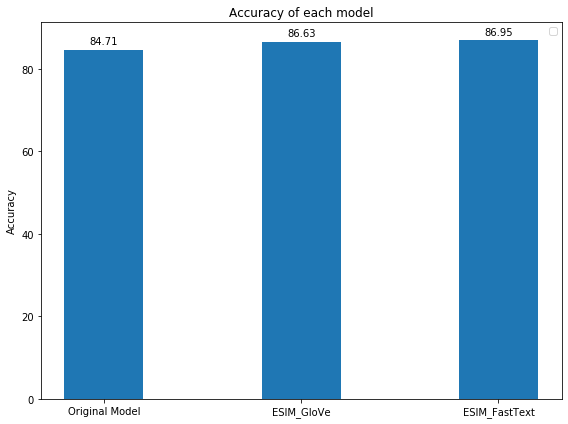


Best Performing model is ESIM-FastText
There is no significant defference between using Glove or FastText Embeddings
The Proposed ESIM-FastText outperforms original model by 2.24%
---------------------------------------------------------------------------------
Taha Samavati - 98722134 - Analysis of final results


In [0]:
def autolabel(rects):
    """Attach a text label above each bar """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

y_preds = [accs[2],accs[1],accs[0]]


method_names=['Original Model','ESIM_GloVe','ESIM_FastText']
accuracy=['Accuracy']

fig, ax = plt.subplots(figsize=(8,6))
labels = method_names

data = np.round(y_preds,2)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars


rects1 = ax.bar(x, data, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of each model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()
print()
print("Best Performing model is ESIM-FastText")
print("There is no significant difference between using Glove or FastText Embeddings")
print("The Proposed ESIM-FastText outperforms original model by 2.24%")
print("---------------------------------------------------------------------------------")
print("Taha Samavati - 98722134 - Analysis of final results")

[0.7933490000228443, 0.8542270019208953, 0.8810454327883241, 0.9051243171637063]


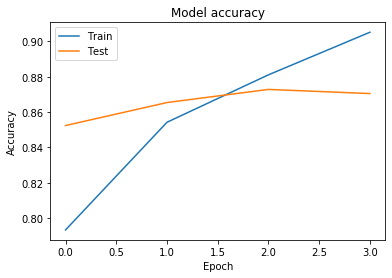

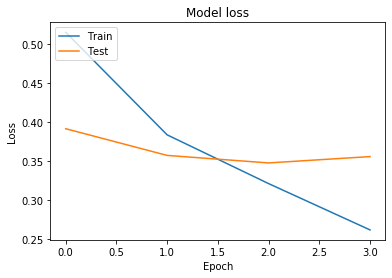

In [0]:
import matplotlib.pyplot as plt
def plot_acc(history, title):

  plt.plot(history.history['acc'])
  print(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def plot_loss(history, title):

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

plot_acc(hist,"Accuracy during training - ESIM GLOVE")
plot_loss(hist,"Loss during training - ESIM GLOVE")

In [0]:
# plot model
model = build_esim()
model.load_weights('/content/gdrive/My Drive/NLP/bilstm-max-ESIM-04-0.8724.hdf5')

plot_model(model, to_file='model.png')

# 6. **Evaluation on SICK dataset - Inference Task**

In [7]:
# download dataset
#! wget "https://zenodo.org/record/2787612/files/SICK.zip?download=1" -P /content/gdrive/My\ Drive/NLP/
!unzip /content/gdrive/My\ Drive/NLP/SICK.zip -d /content/gdrive/My\ Drive/NLP/

Archive:  /content/gdrive/My Drive/NLP/SICK.zip
  inflating: /content/gdrive/My Drive/NLP/readme.txt  
  inflating: /content/gdrive/My Drive/NLP/SICK.txt  


In [0]:
# read dataset
sick_dataset = pd.read_csv('/content/gdrive/My Drive/NLP/SICK.txt',sep="\t")


# preprocess drop nan entries and ignore entries with no label
sick_dataset = sick_dataset.dropna(subset = ['sentence_B'])
sick_dataset = sick_dataset[sick_dataset["entailment_label"] != "-"]

sick_train = sick_dataset[sick_dataset['SemEval_set'] == 'TRAIN']
sick_trial = sick_dataset[sick_dataset['SemEval_set'] == 'TRIAL']
sick_test = sick_dataset[sick_dataset['SemEval_set'] == 'TEST']

# construct label arrays
y_train = sick_train['entailment_label']
y_val = sick_trial['entailment_label']
y_test = sick_test['entailment_label']

# constrauct X_train arrays
x_train_raw = sick_train[['sentence_A','sentence_B']]
x_val_raw = sick_trial[['sentence_A','sentence_B']]
x_test_raw = sick_test[['sentence_A','sentence_B']]

# one hot encode labels
y_train_e = onehot(y_train)
y_val_e = onehot(y_val)
y_test_e = onehot(y_test)

In [11]:
sick_train.head()

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_B_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,NEUTRAL,4.5,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...","A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.2,A_contradicts_B,B_neutral_A,"A group of children playing in a yard, a man i...","A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,ENTAILMENT,4.7,A_entails_B,B_entails_A,"The children are playing outdoors, while a man...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRAIN
3,4,The young boys are playing outdoors and the ma...,There is no boy playing outdoors and there is ...,CONTRADICTION,3.6,A_contradicts_B,B_contradicts_A,"The children are playing outdoors, while a man...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRIAL
4,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.4,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRAIN


In [0]:
# 2.Tokenize
main_train, hypo_train, main_val, hypo_val, main_test, hypo_test=[], [], [], [], [], []

for entry in x_train_raw['sentence_A']:
  main_train.append(entry)
for entry in x_train_raw['sentence_B']:
  hypo_train.append(entry)
for entry in x_val_raw['sentence_A']:
  main_val.append(entry)
for entry in x_val_raw['sentence_B']:
  hypo_val.append(entry)
for entry in x_test_raw['sentence_A']:
  main_test.append(entry)
for entry in x_test_raw['sentence_B']:
  hypo_test.append(entry)

In [0]:
# 4.Convert text to sequence
main_sequences = tokenizer.texts_to_sequences(main_train)
hypo_sequences = tokenizer.texts_to_sequences(hypo_train)
main_sequences_val = tokenizer.texts_to_sequences(main_val)
hypo_sequences_val = tokenizer.texts_to_sequences(hypo_val)
main_sequences_test = tokenizer.texts_to_sequences(main_test)
hypo_sequences_test = tokenizer.texts_to_sequences(hypo_test)
# 5.Zero pad sequences
main_seq_padded = pad_sequences(main_sequences, maxlen=82)
hypo_seq_padded = pad_sequences(hypo_sequences, maxlen=82)
main_seq_padded_val = pad_sequences(main_sequences_val, maxlen=82)
hypo_seq_padded_val = pad_sequences(hypo_sequences_val, maxlen=82)
main_seq_padded_test = pad_sequences(main_sequences_test, maxlen=82)
hypo_seq_padded_test = pad_sequences(hypo_sequences_test, maxlen=82)

In [49]:
EMBEDDING_DIM=300
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# reserve zero for padding
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None :
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 34606 unique tokens.


In [0]:
def build_sick_clf():
  model = build_esim()
  model.load_weights('/content/gdrive/My Drive/NLP/bilstm-max-ESIM-04-0.8724.hdf5')
  # Freeze the layers except the last 2 layers
  for layer in model.layers[:-2]:
      layer.trainable = False
  # Check the trainable status of the individual layers
  for layer in model.layers:
      print(layer, layer.trainable)

  #model = Model(inputs, output)
  model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')
  return model

model = build_sick_clf()

In [63]:
# train ESIM model with FastText
batch_size = 64
n_epoch = 8
model_name='ESIM_SICK_FT'
model_save_path = '/content/gdrive/My Drive/NLP/'+model_name+'-{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list=[checkpoint]
hist = model.fit([main_seq_padded,hypo_seq_padded], y_train_e,
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=([main_seq_padded_val,hypo_seq_padded_val], y_val_e),
          callbacks=callback_list)

Train on 4439 samples, validate on 495 samples
Epoch 1/8
4439/4439 [==============================] - 47s 11ms/step - loss: 0.5014 - acc: 0.8117 - val_loss: 0.3453 - val_acc: 0.8566

Epoch 00001: val_acc improved from -inf to 0.85657, saving model to /content/gdrive/My Drive/NLP/ESIM_SICK_FT-01-0.8566.hdf5
Epoch 2/8
4439/4439 [==============================] - 41s 9ms/step - loss: 0.3206 - acc: 0.8777 - val_loss: 0.3299 - val_acc: 0.8606

Epoch 00002: val_acc improved from 0.85657 to 0.86061, saving model to /content/gdrive/My Drive/NLP/ESIM_SICK_FT-02-0.8606.hdf5
Epoch 3/8
4439/4439 [==============================] - 41s 9ms/step - loss: 0.2938 - acc: 0.8883 - val_loss: 0.3282 - val_acc: 0.8545

Epoch 00003: val_acc did not improve from 0.86061
Epoch 4/8
4439/4439 [==============================] - 40s 9ms/step - loss: 0.2733 - acc: 0.8970 - val_loss: 0.3145 - val_acc: 0.8566

Epoch 00004: val_acc did not improve from 0.86061
Epoch 5/8
4439/4439 [==============================] - 40s 

In [64]:
metrics = model.evaluate([main_seq_padded_test,hypo_seq_padded_test],y_test_e,batch_size=64)
print("ESIM-FastText Accuracy on SICK test-set : "+str(round(metrics[1]*100,2))+" %")
print()

4906/4906 [==============================] - 40s 8ms/step
ESIM-FastText Accuracy on SICK test-set : 88.73 %



# ||===|| Test Sentence Encoder ||===||

In [0]:
def build_encoder():
  model = build_esim()
  model.load_weights('/content/gdrive/My Drive/NLP/bilstm-max-ESIM-04-0.8724.hdf5')
  # Check the trainable status of the individual layers
  model.layers.pop()
  model.layers.pop()

  model.trainable = False
  return model

model = build_encoder()

* **Generate Embedding for a given Sentence**

In [137]:
main_sent = tokenizer.texts_to_sequences(['The kids are playing outdoors near a man'])
hypo_sent = tokenizer.texts_to_sequences(['The kids are playing outdoors near a man'])

main_sent_pad = pad_sequences(main_sent, maxlen=82)
hypo_sent_pad = pad_sequences(hypo_sent, maxlen=82)

layer_name = 'concatenate_18'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([main_sent_pad,hypo_sent_pad])
# embedding for main sentence --------------------------
intermediate_output[:1024]

array([[-0.00986849, -0.00082916,  0.00212319, ...,  0.00308811,
         0.07802185,  0.02487027]], dtype=float32)